In [0]:
!unzip '/content/drive/My Drive/Deep Learning Data/Skin Cancer/train.zip'

Archive:  /content/drive/My Drive/Deep Learning Data/Skin Cancer/train.zip
   creating: train/
   creating: train/melanoma/
  inflating: train/melanoma/ISIC_0010034.jpg  
  inflating: train/melanoma/ISIC_0014795.jpg  
  inflating: train/melanoma/ISIC_0010194.jpg  
  inflating: train/melanoma/ISIC_0015166.jpg  
  inflating: train/melanoma/ISIC_0014163.jpg  
  inflating: train/melanoma/ISIC_0010081.jpg  
  inflating: train/melanoma/ISIC_0015190.jpg  
  inflating: train/melanoma/ISIC_0000445.jpg  
  inflating: train/melanoma/ISIC_0000390.jpg  
  inflating: train/melanoma/ISIC_0000289.jpg  
  inflating: train/melanoma/ISIC_0000466.jpg  
  inflating: train/melanoma/ISIC_0014324.jpg  
  inflating: train/melanoma/ISIC_0013671.jpg  
  inflating: train/melanoma/ISIC_0000171.jpg  
  inflating: train/melanoma/ISIC_0013184.jpg  
  inflating: train/melanoma/ISIC_0000004.jpg  
  inflating: train/melanoma/ISIC_0000049.jpg  
  inflating: train/melanoma/ISIC_0000153.jpg  
  inflating: train/melanoma/IS

In [0]:
!unzip '/content/drive/My Drive/Deep Learning Data/Skin Cancer/valid.zip'

Archive:  /content/drive/My Drive/Deep Learning Data/Skin Cancer/valid.zip
   creating: valid/
   creating: valid/melanoma/
  inflating: valid/melanoma/ISIC_0012288.jpg  
  inflating: valid/melanoma/ISIC_0013702.jpg  
  inflating: valid/melanoma/ISIC_0012099.jpg  
  inflating: valid/melanoma/ISIC_0014809.jpg  
  inflating: valid/melanoma/ISIC_0014428.jpg  
  inflating: valid/melanoma/ISIC_0014302.jpg  
  inflating: valid/melanoma/ISIC_0014985.jpg  
  inflating: valid/melanoma/ISIC_0014931.jpg  
  inflating: valid/melanoma/ISIC_0013518.jpg  
  inflating: valid/melanoma/ISIC_0013501.jpg  
  inflating: valid/melanoma/ISIC_0015243.jpg  
  inflating: valid/melanoma/ISIC_0013232.jpg  
  inflating: valid/melanoma/ISIC_0014857.jpg  
  inflating: valid/melanoma/ISIC_0012434.jpg  
  inflating: valid/melanoma/ISIC_0013644.jpg  
  inflating: valid/melanoma/ISIC_0013736.jpg  
  inflating: valid/melanoma/ISIC_0012151.jpg  
  inflating: valid/melanoma/ISIC_0013549.jpg  
  inflating: valid/melanoma/IS

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
## Do some EDA
classes = os.listdir('/content/train')
print(f'Number of labels in the dataset: {len(classes)}')

Number of labels in the dataset: 3


In [0]:
no_melanoma = len(os.listdir('/content/train/melanoma'))
no_nevus = len(os.listdir('/content/train/nevus'))
no_seborrheic = len(os.listdir('/content/train/seborrheic_keratosis'))

In [0]:
print(f'Number of images in each classes are {no_melanoma} images, {no_nevus} images, and {no_seborrheic} images, respectively')

Number of images in each classes are 374 images, 1372 images, and 254 images, respectively


In [0]:
## Since we have imbalance dataset, i will weight the loss accordingly
melanoma_weight = no_melanoma/(no_nevus + no_seborrheic)
nevus_weight = no_nevus/(no_melanoma + no_seborrheic)
seborrheic_weight = no_seborrheic/(no_melanoma + no_nevus)

pos_weights = np.array([1/melanoma_weight, 1/nevus_weight, 1/seborrheic_weight])

In [0]:
pos_weights

array([4.34759358, 0.45772595, 6.87401575])

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

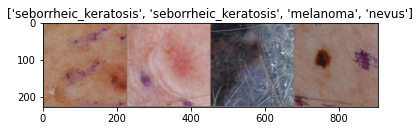

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
!pip install pytorch-ignite

import os
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import CosineAnnealingScheduler, PiecewiseLinear, create_lr_scheduler_with_warmup, ProgressBar

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
pretrained_model = models.densenet121(pretrained = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [0]:
## Modify classification layer

num_ftrs = pretrained_model.classifier.in_features
pretrained_model.classifier = nn.Linear(num_ftrs, len(classes))
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = train_model(pretrained_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9347 Acc: 0.6330
val Loss: 1.0609 Acc: 0.5400

Epoch 1/24
----------
train Loss: 0.8875 Acc: 0.6475
val Loss: 1.0641 Acc: 0.6133

Epoch 2/24
----------
train Loss: 0.8200 Acc: 0.6620
val Loss: 0.9523 Acc: 0.7000

Epoch 3/24
----------
train Loss: 0.7679 Acc: 0.6970
val Loss: 0.9249 Acc: 0.6400

Epoch 4/24
----------
train Loss: 0.7693 Acc: 0.6760
val Loss: 0.7664 Acc: 0.7267

Epoch 5/24
----------
train Loss: 0.6917 Acc: 0.7170
val Loss: 0.7065 Acc: 0.7267

Epoch 6/24
----------
train Loss: 0.6748 Acc: 0.7245
val Loss: 0.6559 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.5976 Acc: 0.7410
val Loss: 0.5753 Acc: 0.7533

Epoch 8/24
----------
train Loss: 0.5866 Acc: 0.7565
val Loss: 0.5891 Acc: 0.7400

Epoch 9/24
----------
train Loss: 0.5779 Acc: 0.7680
val Loss: 0.6073 Acc: 0.7467

Epoch 10/24
----------
train Loss: 0.5559 Acc: 0.7775
val Loss: 0.5799 Acc: 0.7467

Epoch 11/24
----------
train Loss: 0.5363 Acc: 0.7860
val Loss: 0.6023 Acc: 0.7467

Ep

In [0]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Deep Learning Data/Skin Cancer')

IsADirectoryError: ignored

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

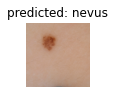

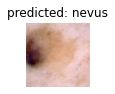

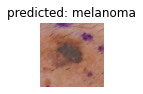

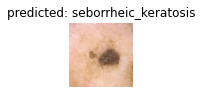

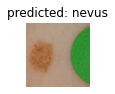

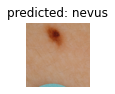

In [0]:
visualize_model(model_ft)


In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9207 Acc: 0.6465
val Loss: 0.9651 Acc: 0.5867

Epoch 1/24
----------


KeyboardInterrupt: ignored